In [13]:
pip install codecarbon --quiet

Note: you may need to restart the kernel to use updated packages.


In [14]:
import os
import numpy as np
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

In [15]:
# ===========================
# Feature Extraction
# ===========================

def extract_spectrogram(path, sr=12000, duration=1.0, augment=False):
    y, _ = librosa.load(path, sr=sr, mono=True, duration=duration)
    
    if augment:
        if np.random.rand() < 0.3:
            y = librosa.effects.pitch_shift(y, sr=sr, n_steps=np.random.choice([-2, -1, 1, 2]))
        if np.random.rand() < 0.3:
            y = librosa.effects.time_stretch(y, rate=np.random.uniform(0.9, 1.1))
        if np.random.rand() < 0.3:
            y += 0.005 * np.random.randn(len(y))

    target_length = int(sr * duration)
    if len(y) < target_length:
        y = np.pad(y, (0, target_length - len(y)), 'constant')
    else:
        y = y[:target_length]

    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=512, hop_length=128, n_mels=128)
    log_S = librosa.power_to_db(S)
    return log_S

In [16]:
# ===========================
# PyTorch Dataset
# ===========================

class AudioDataset(Dataset):
    def __init__(self, folder, label_encoder=None, augment=False):
        self.file_paths = []
        self.labels = []
        self.augment = augment

        for fname in os.listdir(folder):
            if fname.endswith(".wav"):
                label = fname.split("_")[0]
                self.file_paths.append(os.path.join(folder, fname))
                self.labels.append(label)

        if label_encoder is None:
            self.le = LabelEncoder()
            self.labels = self.le.fit_transform(self.labels)
        else:
            self.le = label_encoder
            self.labels = self.le.transform(self.labels)

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        spec = extract_spectrogram(self.file_paths[idx], augment=self.augment)
        spec = spec.astype(np.float32)
        spec_tensor = self.transform(spec)
        label = self.labels[idx]
        return spec_tensor, label

In [17]:
# ===========================
# Model
# ===========================

class AudioResNet(nn.Module):
    def __init__(self, num_classes):
        super(AudioResNet, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)

In [18]:
# ===========================
# Training Loop
# ===========================

def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels.data)
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct.double() / total
    return epoch_loss, epoch_acc.item()

def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_labels, all_outputs = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels.data)
            total += labels.size(0)

            all_labels.append(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct.double() / total
    all_labels = np.concatenate(all_labels)
    all_outputs = np.concatenate(all_outputs)
    return epoch_loss, epoch_acc.item(), all_labels, all_outputs

In [19]:
# ===========================
# Load Data
# ===========================

train_folder = "/kaggle/input/stage2/data/train"
test_folder = "/kaggle/input/stage2/data/test"

train_dataset = AudioDataset(train_folder, augment=True)
test_dataset = AudioDataset(test_folder, label_encoder=train_dataset.le, augment=False)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(train_dataset.le.classes_)

model = AudioResNet(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
# ===========================
# Train
# ===========================

num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train_model(model, train_loader, criterion, optimizer, device)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(


Epoch 1/10 - Train Loss: 0.9397, Train Acc: 0.6141
Epoch 2/10 - Train Loss: 0.7870, Train Acc: 0.6816
Epoch 3/10 - Train Loss: 0.7403, Train Acc: 0.6931
Epoch 4/10 - Train Loss: 0.7082, Train Acc: 0.7150
Epoch 5/10 - Train Loss: 0.6693, Train Acc: 0.7289
Epoch 6/10 - Train Loss: 0.6393, Train Acc: 0.7358
Epoch 7/10 - Train Loss: 0.6311, Train Acc: 0.7427
Epoch 8/10 - Train Loss: 0.6081, Train Acc: 0.7546
Epoch 9/10 - Train Loss: 0.6052, Train Acc: 0.7502
Epoch 10/10 - Train Loss: 0.5862, Train Acc: 0.7614


[codecarbon WARNING @ 18:48:26] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 18:48:26] [setup] RAM Tracking...
[codecarbon INFO @ 18:48:26] [setup] CPU Tracking...


Validation Loss: 0.6736, Validation Acc: 0.7301


[codecarbon WARNING @ 18:48:28] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 18:48:28] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 18:48:28] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 18:48:28] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 18:48:28] [setup] GPU Tracking...
[codecarbon INFO @ 18:48:28] Tracking Nvidia GPU via pynvml
[codecarbon WARNING @ 18:48:28] Failed to retrieve gpu total energy consumption
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/codecarbon/core/gpu.py", line 116, in _get_total_energy_consumption
    return pynvml.nvmlDeviceGetTotalEnergyConsumption(self.handle)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


🔧 Training Time: 0.47 m.seconds
🔋 Energy Emissions: 0.013646 mg CO₂

                 precision    recall  f1-score   support

backgroundnoise       0.54      0.82      0.65       402
 brokenbranches       0.83      0.76      0.79       402
      footsteps       0.85      0.73      0.79       402
        gunshot       0.85      0.61      0.71       402

       accuracy                           0.73      1608
      macro avg       0.77      0.73      0.74      1608
   weighted avg       0.77      0.73      0.74      1608

AUC for class backgroundnoise: 0.8626
AUC for class brokenbranches: 0.9351
AUC for class footsteps: 0.9091
AUC for class gunshot: 0.8839
Macro-average AUC: 0.8977


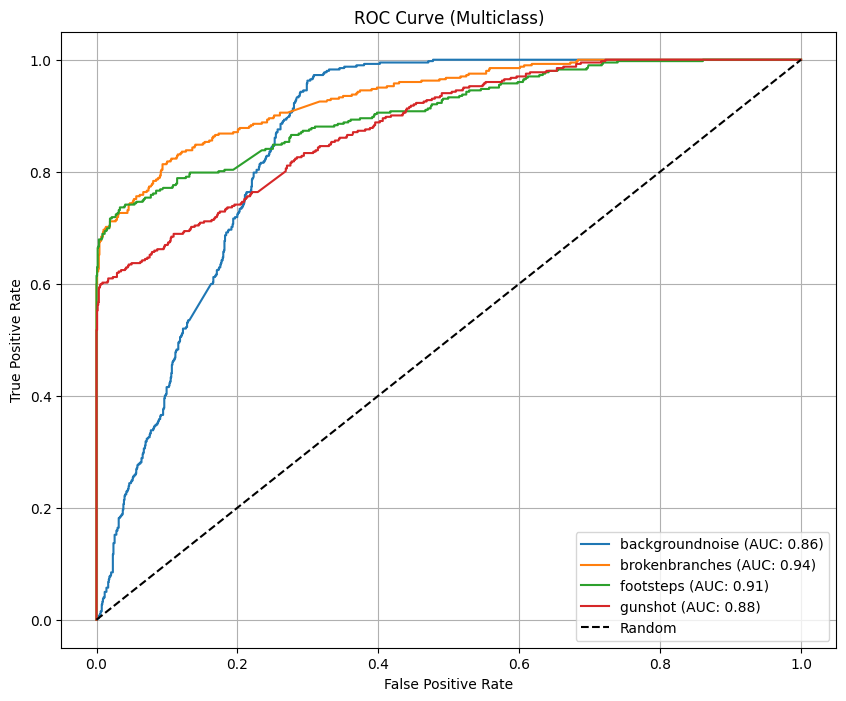

In [ ]:
# ===========================
# Evaluate
# ===========================
import time
from codecarbon import EmissionsTracker


# === Track Energy + Time ===
tracker = EmissionsTracker(project_name="pred")
tracker.start()
start_time = time.time()

val_loss, val_acc, y_true, y_scores = evaluate_model(model, test_loader, criterion, device)
print(f"Validation Loss: {val_loss:.4f}, Validation Acc: {val_acc:.4f}")
y_pred = np.argmax(y_scores, axis=1)

train_time = time.time() - start_time
emissions = tracker.stop()

print(f"\n🔧 Training Time: {train_time*1000:.2f} m.seconds")
print(f"🔋 Energy Emissions: {emissions*1000000:.6f} mg CO₂\n")

print(classification_report(y_true, y_pred, target_names=train_dataset.le.classes_))

# AUC per class
y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
auc_scores = roc_auc_score(y_true_bin, y_scores, average=None)

for i, class_name in enumerate(train_dataset.le.classes_):
    print(f"AUC for class {class_name}: {auc_scores[i]:.4f}")

macro_auc = roc_auc_score(y_true_bin, y_scores, average="macro")
print(f"Macro-average AUC: {macro_auc:.4f}")

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_scores[:, i])
    plt.plot(fpr, tpr, label=f'{train_dataset.le.classes_[i]} (AUC: {auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Multiclass)')
plt.legend()
plt.grid(True)
plt.show()